# packages and settings 

import python packages

In [1]:
import collections
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycircos
from pybedtools import BedTool
from pycircos import Garc, Gcircle

enable rpy2

In [2]:
# enables the gaR magic,  not neceasary  if you’ve already done this
%load_ext rpy2.ipython
# %reload_ext rpy2.ipython

import R libraries

In [3]:
%%R
# 可以再%%R后面放光标 cmd + i
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# 初步探索poisson table
- log2_FC: log2(treat_count.norm/ctrl_count.norm), 如果ctrl_count.norm不存在，就用 chr 突变背景
- log2_FC_mut: log2(treat_mut_count.norm/ctrl_mut_count.norm), 如果ctrl_mut_count.norm不存在，就用 chr 突变背景
- region_block_state: B-Blocked, S-SNV, N-Non-SNV

In [4]:
file = '../poisson_res/poisson_res_all.tsv.gz'

In [5]:
df = pd.read_csv(file, header=0, index_col=None, sep='\t')
df.head()

,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_count.norm,treat_count.norm,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR
0,DetectSeq_ATP8-DddA11_REP-1,chr1,16395,16418,chr1_16395_16418,11,0,11,"chr1_16395_CT,chr1_16397_C.,chr1_16403_CT,chr1...",N-N-N-N-N-N-N-N-N-N-N,...,0.144296,0.113256,0.0,0.011922,"0,1,2,3,4,5,6,7,8,9,10,11 53,4,0,0,0,0,0,0,0,0...",-0.349446,0.557555,TestOK,0.377620,0.842215
1,DetectSeq_ATP8-DddA11_REP-1,chr1,16534,16540,chr1_16534_16540,4,1,3,"chr1_16534_CT,chr1_16538_CT,chr1_16539_C.,chr1...",B-N-N-N,...,0.091135,0.047687,0.0,0.000000,"0,1,2,3,4 36,0,0,0,0 8,0,0,0,0",-0.934408,NaN,TestOK,0.841752,0.842215
2,DetectSeq_ATP8-DddA11_REP-1,chr1,31029,31037,chr1_31029_31037,4,1,3,"chr1_31029_GA,chr1_31030_G.,chr1_31031_GA,chr1...",B-N-N-N,...,0.005063,0.035765,0.0,0.005961,"0,1,2,3,4 2,0,0,0,0 5,0,1,0,0",2.820479,-0.442445,TestOK,0.582932,0.842215
3,DetectSeq_ATP8-DddA11_REP-1,chr1,56485,56490,chr1_56485_56490,4,1,3,"chr1_56485_CT,chr1_56487_CT,chr1_56488_C.,chr1...",B-N-N-N,...,0.025315,0.041726,0.0,0.005961,"0,1,2,3,4 10,0,0,0,0 6,0,1,0,0",0.720943,-0.442445,TestOK,0.582932,0.842215
4,DetectSeq_ATP8-DddA11_REP-1,chr1,56638,56647,chr1_56638_56647,3,0,3,"chr1_56638_CT,chr1_56641_C.,chr1_56647_CT",N-N-N,...,0.040504,0.077491,0.0,0.000000,"0,1,2,3 16,0,0,0 3,10,0,0",0.935956,NaN,TestOK,0.841752,0.842215


In [6]:
# df.info()

In [7]:
# df.isna().sum()

In [8]:
# # 查看一下两列 NA 是什么
# test_df = df.query('region_highest_site_index.isna()')
# test2_df = df.query('log2_FC_mut.isna()')

In [9]:
df = df.assign(bed_name=df.mpmat_index + '_highest_' +
               df.region_highest_site_index,
               strand='.')
df = df[df['<sample>'] != 'test']
df

,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR,bed_name,strand
0,DetectSeq_ATP8-DddA11_REP-1,chr1,16395,16418,chr1_16395_16418,11,0,11,"chr1_16395_CT,chr1_16397_C.,chr1_16403_CT,chr1...",N-N-N-N-N-N-N-N-N-N-N,...,0.0,0.011922,"0,1,2,3,4,5,6,7,8,9,10,11 53,4,0,0,0,0,0,0,0,0...",-0.349446,0.557555,TestOK,0.377620,0.842215,chr1_16395_16418_highest_chr1_16395_CT,.
1,DetectSeq_ATP8-DddA11_REP-1,chr1,16534,16540,chr1_16534_16540,4,1,3,"chr1_16534_CT,chr1_16538_CT,chr1_16539_C.,chr1...",B-N-N-N,...,0.0,0.000000,"0,1,2,3,4 36,0,0,0,0 8,0,0,0,0",-0.934408,NaN,TestOK,0.841752,0.842215,chr1_16534_16540_highest_chr1_16538_CT,.
2,DetectSeq_ATP8-DddA11_REP-1,chr1,31029,31037,chr1_31029_31037,4,1,3,"chr1_31029_GA,chr1_31030_G.,chr1_31031_GA,chr1...",B-N-N-N,...,0.0,0.005961,"0,1,2,3,4 2,0,0,0,0 5,0,1,0,0",2.820479,-0.442445,TestOK,0.582932,0.842215,chr1_31029_31037_highest_chr1_31031_GA,.
3,DetectSeq_ATP8-DddA11_REP-1,chr1,56485,56490,chr1_56485_56490,4,1,3,"chr1_56485_CT,chr1_56487_CT,chr1_56488_C.,chr1...",B-N-N-N,...,0.0,0.005961,"0,1,2,3,4 10,0,0,0,0 6,0,1,0,0",0.720943,-0.442445,TestOK,0.582932,0.842215,chr1_56485_56490_highest_chr1_56487_CT,.
4,DetectSeq_ATP8-DddA11_REP-1,chr1,56638,56647,chr1_56638_56647,3,0,3,"chr1_56638_CT,chr1_56641_C.,chr1_56647_CT",N-N-N,...,0.0,0.000000,"0,1,2,3 16,0,0,0 3,10,0,0",0.935956,NaN,TestOK,0.841752,0.842215,chr1_56638_56647_highest_chr1_56638_CT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6421000,DetectSeq_SIRT6-DddA11_REP-1,chrX,155984850,155984857,chrX_155984850_155984857,2,0,2,"chrX_155984850_CT,chrX_155984857_CT",N-N,...,0.0,0.000000,"0,1,2 0,0,0 5,7,0",0.207009,NaN,TestOK,0.806282,0.857628,chrX_155984850_155984857_highest_chrX_15598485...,.
6421001,DetectSeq_SIRT6-DddA11_REP-1,chrX,155984970,155984999,chrX_155984970_155984999,7,0,7,"chrX_155984970_CT,chrX_155984977_C.,chrX_15598...",N-N-N-N-N-N-N,...,0.0,0.005561,"0,1,2,3,4,5,6,7 0,0,0,0,0,0,0,0 11,2,1,0,0,0,0,0",0.429401,-0.274156,TestOK,0.528695,0.857628,chrX_155984970_155984999_highest_chrX_15598497...,.
6421002,DetectSeq_SIRT6-DddA11_REP-1,chrX,155985095,155985105,chrX_155985095_155985105,3,0,3,"chrX_155985095_GA,chrX_155985099_G.,chrX_15598...",N-N-N,...,0.0,0.000000,"0,1,2,3 0,0,0,0 1,0,0,0",-3.377953,NaN,TestOK,0.806282,0.857628,chrX_155985095_155985105_highest_chrX_15598509...,.
6421003,DetectSeq_SIRT6-DddA11_REP-1,chrX,155988525,155988531,chrX_155988525_155988531,4,0,4,"chrX_155988525_CT,chrX_155988529_C.,chrX_15598...",N-N-N-N,...,0.0,0.000000,"0,1,2,3,4 0,0,0,0,0 2,0,0,0,0",-2.377953,NaN,TestOK,0.806282,0.857628,chrX_155988525_155988531_highest_chrX_15598852...,.


# find significant region

## strict selection 

In [10]:
df_sign_strict = (
    df.query('FDR <= 0.0001').query('log2_FC_mut >= 2').query(
        'ctrl_mut_count <= 1').query('`treat_mut_count.norm` * 100 >= 10').
    query('treat_mut_count >= 20').query(
        'treat_mut_count / treat_count >= 0.15').query(
            'region_block_site_num <= 1').query(
                'region_highest_site_mut_ratio >= 0.35')  # 1892
)

print(df_sign_strict.shape[0])
df_sign_strict.groupby('<sample>').describe()

1892


region_start                              \
                                    count          mean           std   
<sample>                                                                
DetectSeq_ATP8-DddA11_REP-1          72.0  7.232027e+07  5.418565e+07   
DetectSeq_ATP8-DddA6_REP-1          189.0  7.886078e+07  5.397664e+07   
DetectSeq_ATP8-DddAwt_REP-1          27.0  4.491637e+07  4.291506e+07   
DetectSeq_JAK2-DddA11_REP-1         400.0  7.720246e+07  5.466300e+07   
DetectSeq_SIRT6-DddA11_REP-1       1204.0  7.768406e+07  5.564547e+07   

                                                                  \
                                    min          25%         50%   
<sample>                                                           
DetectSeq_ATP8-DddA11_REP-1    631391.0  26704962.00  62013707.5   
DetectSeq_ATP8-DddA6_REP-1     631391.0  35339095.00  72688097.0   
DetectSeq_ATP8-DddAwt_REP-1    631391.0  17145676.50  27147712.0   
DetectSeq_JAK2-DddA11_REP-1   1279842.0  33854748.25  66652709.0   
DetectSeq_SIRT6-DddA11_REP-1   242415.0  33904291.75  67106716.5   

                                                        region_end  \
                                       75%          max      count   
<sample>                                                             
DetectSeq_ATP8-DddA11_REP-1   1.122798e+08  238396642.0       72.0   
DetectSeq_ATP8-DddA6_REP-1    1.148110e+08  226406759.0      189.0   
DetectSeq_ATP8-DddAwt_REP-1   5.676308e+07  173839060.0       27.0   
DetectSeq_JAK2-DddA11_REP-1   1.163821e+08  246689645.0      400.0   
DetectSeq_SIRT6-DddA11_REP-1  1.123429e+08  248905893.0     1204.0   

                                            ...       p_value                \
                                      mean  ...           75%           max   
<sample>                                    ...                               
DetectSeq_ATP8-DddA11_REP-1   7.232032e+07  ...  2.953279e-10  1.226002e-08   
DetectSeq_ATP8-DddA6_REP-1    7.886083e+07  ...  4.238782e-09  3.022062e-08   
DetectSeq_ATP8-DddAwt_REP-1   4.491641e+07  ...  3.872361e-10  2.584274e-09   
DetectSeq_JAK2-DddA11_REP-1   7.720249e+07  ...  2.309763e-10  3.415243e-08   
DetectSeq_SIRT6-DddA11_REP-1  7.768411e+07  ...  3.257744e-09  2.089933e-07   

                                 FDR                                     \
                               count      mean       std            min   
<sample>                                                                  
DetectSeq_ATP8-DddA11_REP-1     72.0  0.000008  0.000019   0.000000e+00   
DetectSeq_ATP8-DddA6_REP-1     189.0  0.000012  0.000022   0.000000e+00   
DetectSeq_ATP8-DddAwt_REP-1     27.0  0.000009  0.000017   0.000000e+00   
DetectSeq_JAK2-DddA11_REP-1    400.0  0.000005  0.000014  7.206266e-102   
DetectSeq_SIRT6-DddA11_REP-1  1204.0  0.000007  0.000018  8.602823e-153   

                                                                        \
                                       25%           50%           75%   
<sample>                                                                 
DetectSeq_ATP8-DddA11_REP-1   3.609762e-17  6.514572e-11  3.036639e-06   
DetectSeq_ATP8-DddA6_REP-1    1.511549e-12  9.258856e-08  1.664663e-05   
DetectSeq_ATP8-DddAwt_REP-1   8.475808e-08  4.466082e-07  1.031558e-05   
DetectSeq_JAK2-DddA11_REP-1   9.844659e-19  4.976689e-11  6.804493e-07   
DetectSeq_SIRT6-DddA11_REP-1  7.967822e-17  1.283779e-09  2.256525e-06   

                                        
                                   max  
<sample>                                
DetectSeq_ATP8-DddA11_REP-1   0.000098  
DetectSeq_ATP8-DddA6_REP-1    0.000096  
DetectSeq_ATP8-DddAwt_REP-1   0.000056  
DetectSeq_JAK2-DddA11_REP-1   0.000073  
DetectSeq_SIRT6-DddA11_REP-1  0.000097  

[5 rows x 160 columns]

In [11]:
df_sign_strict.isna().sum().sum()

0

## lenient selection

In [14]:
# nature protocol standard
# df_sign_lenient = (df
#                    .query('FDR <= 0.01')
#                    .query('log2_FC_mut >= 2')
#                    .query('ctrl_mut_count <= 1')
#                    .query('`treat_mut_count.norm` * 100 >= 5')
#                    .query('treat_mut_count >= 10')
#                    .query('treat_mut_count / treat_count >= 0.15')
#                    .query('region_block_site_num <= 1')
#                    .query('region_highest_site_mut_ratio >= 0.30')  # 4007
#                    )

# print(df_sign_lenient.shape[0])
# df_sign_lenient.groupby('<sample>').describe()

# 2022-10-27 update
df_sign_lenient = (df
                   .query('FDR <= 0.01').query('log2_FC_mut >= 2')
                   .query('ctrl_mut_count <= 1')
                   .query('`treat_mut_count.norm` * 100 >= 5')
                   .query('treat_mut_count >= 10')
                   .query('treat_mut_count / treat_count >= 0.15')
                   .query('region_block_site_num <= 1')
                   .query('region_highest_site_mut_ratio >= 0.30')  # 4007
                   )

print(df_sign_lenient.shape[0])
df_sign_lenient.groupby('<sample>').describe()

4007


region_start                              \
                                    count          mean           std   
<sample>                                                                
DetectSeq_ATP8-DddA11_REP-1         136.0  7.806753e+07  5.564656e+07   
DetectSeq_ATP8-DddA6_REP-1          490.0  8.236542e+07  5.517979e+07   
DetectSeq_ATP8-DddAwt_REP-1          56.0  5.362142e+07  4.577483e+07   
DetectSeq_JAK2-DddA11_REP-1         658.0  7.490521e+07  5.412918e+07   
DetectSeq_SIRT6-DddA11_REP-1       2667.0  7.902458e+07  5.575653e+07   

                                                                  \
                                    min          25%         50%   
<sample>                                                           
DetectSeq_ATP8-DddA11_REP-1    631391.0  33692937.75  69108378.0   
DetectSeq_ATP8-DddA6_REP-1      58741.0  36676013.50  74671918.5   
DetectSeq_ATP8-DddAwt_REP-1    631391.0  17355850.00  44585004.5   
DetectSeq_JAK2-DddA11_REP-1   1056219.0  32369589.25  63261637.0   
DetectSeq_SIRT6-DddA11_REP-1    79700.0  34749176.00  68550649.0   

                                                        region_end  \
                                       75%          max      count   
<sample>                                                             
DetectSeq_ATP8-DddA11_REP-1   1.176057e+08  242043276.0      136.0   
DetectSeq_ATP8-DddA6_REP-1    1.189550e+08  245995442.0      490.0   
DetectSeq_ATP8-DddAwt_REP-1   7.035096e+07  201232409.0       56.0   
DetectSeq_JAK2-DddA11_REP-1   1.094002e+08  246696632.0      658.0   
DetectSeq_SIRT6-DddA11_REP-1  1.163118e+08  248905893.0     2667.0   

                                            ...       p_value                \
                                      mean  ...           75%           max   
<sample>                                    ...                               
DetectSeq_ATP8-DddA11_REP-1   7.806758e+07  ...  5.923322e-08  1.847701e-06   
DetectSeq_ATP8-DddA6_REP-1    8.236547e+07  ...  5.322003e-07  6.243530e-06   
DetectSeq_ATP8-DddAwt_REP-1   5.362146e+07  ...  1.484702e-07  8.404122e-07   
DetectSeq_JAK2-DddA11_REP-1   7.490524e+07  ...  1.170807e-07  7.326257e-06   
DetectSeq_SIRT6-DddA11_REP-1  7.902463e+07  ...  3.484243e-06  4.180053e-05   

                                 FDR                                     \
                               count      mean       std            min   
<sample>                                                                  
DetectSeq_ATP8-DddA11_REP-1    136.0  0.001004  0.002092   0.000000e+00   
DetectSeq_ATP8-DddA6_REP-1     490.0  0.001365  0.002426   0.000000e+00   
DetectSeq_ATP8-DddAwt_REP-1     56.0  0.001748  0.002776   0.000000e+00   
DetectSeq_JAK2-DddA11_REP-1    658.0  0.000832  0.002095  7.206266e-102   
DetectSeq_SIRT6-DddA11_REP-1  2667.0  0.001171  0.002324  8.602823e-153   

                                                                              
                                       25%           50%       75%       max  
<sample>                                                                      
DetectSeq_ATP8-DddA11_REP-1   8.085970e-12  5.023110e-06  0.000407  0.009126  
DetectSeq_ATP8-DddA6_REP-1    2.017237e-08  6.874875e-05  0.001158  0.009637  
DetectSeq_ATP8-DddAwt_REP-1   4.466082e-07  4.359292e-05  0.002067  0.009224  
DetectSeq_JAK2-DddA11_REP-1   7.891722e-14  2.819972e-07  0.000230  0.009935  
DetectSeq_SIRT6-DddA11_REP-1  1.249246e-10  9.457196e-06  0.001175  0.009690  

[5 rows x 160 columns]

In [15]:
df_sign_lenient.isna().sum().sum()

0

In [16]:
df = df_sign_lenient
print(df.shape)
df.head()

(4007, 30)


,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR,bed_name,strand
67,DetectSeq_ATP8-DddA11_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.000000,2.801598,"0,1,2,3 22,0,0,0 689,406,500,0",7.415426,8.434072,TestOK,9.573874e-183,1.536847e-177,chr1_631391_631393_highest_chr1_631392_CT,.
69,DetectSeq_ATP8-DddA11_REP-1,chr1,631778,631791,chr1_631778_631791,3,0,3,"chr1_631778_CT,chr1_631787_CT,chr1_631791_CT",N-N-N,...,0.000000,3.260583,"0,1,2,3 40,0,0,0 534,278,413,258",6.447891,8.652952,TestOK,2.915445e-214,5.348597e-209,chr1_631778_631791_highest_chr1_631791_CT,.
74,DetectSeq_ATP8-DddA11_REP-1,chr1,633067,633147,chr1_633067_633147,11,0,11,"chr1_633067_GA,chr1_633068_GA,chr1_633073_GA,c...",N-N-N-N-N-N-N-N-N-N-N,...,0.000000,3.409604,"0,1,2,3,4,5,6,7,8,9,10,11 33,0,0,0,0,0,0,0,0,0...",7.466665,8.717426,TestOK,1.596361e-224,3.416748e-219,chr1_633067_633147_highest_chr1_633100_GA,.
75,DetectSeq_ATP8-DddA11_REP-1,chr1,633244,633286,chr1_633244_633286,9,0,9,"chr1_633244_GA,chr1_633246_GA,chr1_633249_GA,c...",N-N-N-N-N-N-N-N-N,...,0.000000,1.001422,"0,1,2,3,4,5,6,7,8,9 19,3,0,0,0,0,0,0,0,0 564,1...",6.655668,6.949872,TestOK,2.429064e-61,1.733004e-56,chr1_633244_633286_highest_chr1_633286_GA,.
78,DetectSeq_ATP8-DddA11_REP-1,chr1,633376,633442,chr1_633376_633442,20,0,20,"chr1_633376_CT,chr1_633377_CT,chr1_633378_C.,c...",N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N,...,0.002532,1.591546,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18...",6.225823,9.296213,TestOK,1.421498e-100,1.404222e-95,chr1_633376_633442_highest_chr1_633384_CT,.


## fix mpmat_index (add old into it) -> df_pois

In [17]:
df_old_id = pd.read_csv(
    "../tables/20220312-DdCBE-off_target_type.FinallistV4.CheckPrimer.AddV4ID.tsv",
    sep='\t', header=0, usecols=['region_id'],)
df_old_id.region_id.describe()

count                     6881
unique                    6881
top       chr1_1471366_1471410
freq                         1
Name: region_id, dtype: object

In [18]:
df_old_id[['chrom', 'start', 'end'
           ]] = pd.Series(df_old_id.region_id.unique()).str.split('_',
                                                                  expand=True)
df_old_id = df_old_id.iloc[:, 1:4]
df_old_id['start'] = df_old_id['start'].astype(int)
df_old_id['end'] = df_old_id['end'].astype(int)
df_old_id

,chrom,start,end
0,chr1,1471366,1471410
1,chr1,1693068,1693084
2,chr1,2044988,2044998
3,chr1,5806517,5806533
4,chr1,5983069,5983085
...,...,...,...
6876,chrX,153669436,153669453
6877,chrX,154373542,154373556
6878,chrX,155049205,155049215
6879,chrX,155068321,155068358


In [19]:
df_old_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6881 entries, 0 to 6880
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   chrom   6881 non-null   object
 1   start   6881 non-null   int64 
 2   end     6881 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 161.4+ KB


In [20]:
df_new_id = pd.Series(df.mpmat_index.unique()).str.split('_', expand=True)
df_new_id.columns = ['chrom', 'start', 'end']
df_new_id['start'] = df_new_id['start'].astype(int)
df_new_id['end'] = df_new_id['end'].astype(int)

df_new_id

,chrom,start,end
0,chr1,631391,631393
1,chr1,631778,631791
2,chr1,633067,633147
3,chr1,633244,633286
4,chr1,633376,633442
...,...,...,...
3227,chrX,154448849,154448867
3228,chrX,154457770,154457792
3229,chrX,154457793,154457822
3230,chrX,154924102,154924198


In [21]:
bed_new = BedTool.from_dataframe(df_new_id)
bed_nat = BedTool.from_dataframe(df_old_id)

> https://bedtools.readthedocs.io/en/latest/content/tools/intersect.html

![](https://tva1.sinaimg.cn/large/008vxvgGly1h7jy4v629sj30ld0j9wg7.jpg)

In [22]:
df_bed_to_fix = bed_new.intersect(bed_nat, loj=True).to_dataframe()
df_bed_to_fix.columns = ['chrom', 'start', 'end', 'chrom2', 'start2', 'end2']

df_bed_to_fix

,chrom,start,end,chrom2,start2,end2
0,chr1,631391,631393,.,-1,-1
1,chr1,631778,631791,.,-1,-1
2,chr1,633067,633147,.,-1,-1
3,chr1,633244,633286,.,-1,-1
4,chr1,633376,633442,.,-1,-1
...,...,...,...,...,...,...
3229,chrX,154448849,154448867,.,-1,-1
3230,chrX,154457770,154457792,.,-1,-1
3231,chrX,154457793,154457822,.,-1,-1
3232,chrX,154924102,154924198,.,-1,-1


In [23]:
# end2 为-1 代表老点不存在，
# end2 有值说明，新老点重合，以老点 region 坐标为准进行替换
# df_test = df_bed_to_fix.query('end2 != -1')
# abs((df_test.end2 - df_test.start2 - df_test.end + df_test.start)).describe()

# 唯一标识mpmat_index

df_bed_to_fix['mpmat_index'] = df_bed_to_fix['chrom'] + '_' + \
    df_bed_to_fix['start'].astype(str) + '_' + df_bed_to_fix['end'].astype(str)

df_bed_to_fix_part1 = df_bed_to_fix.query('end2 == -1')[[
    'mpmat_index', 'chrom', 'start', 'end'
]].copy()
df_bed_to_fix_part2 = df_bed_to_fix.query('end2 != -1')[[
    'mpmat_index', 'chrom2', 'start2', 'end2'
]].copy()

df_bed_to_fix_part1.columns = [
    'mpmat_index', 'chr_name', 'region_start', 'region_end'
]
df_bed_to_fix_part2.columns = [
    'mpmat_index', 'chr_name', 'region_start', 'region_end'
]

df_bed_fixed_coordinate = pd.concat([df_bed_to_fix_part1, df_bed_to_fix_part2],
                                    axis=0)
df_bed_fixed_coordinate

,mpmat_index,chr_name,region_start,region_end
0,chr1_631391_631393,chr1,631391,631393
1,chr1_631778_631791,chr1,631778,631791
2,chr1_633067_633147,chr1,633067,633147
3,chr1_633244_633286,chr1,633244,633286
4,chr1_633376_633442,chr1,633376,633442
...,...,...,...,...
3170,chrX_41024494_41024536,chrX,41024523,41024536
3186,chrX_72126743_72126762,chrX,72126743,72126762
3199,chrX_103211187_103211215,chrX,103211203,103211249
3220,chrX_132292956_132292983,chrX,132292961,132292983


In [26]:
# 发现两个 duplicated 的 mpmat_index，check 一下为什么
# print(df_bed_fixed_coordinate[df_bed_fixed_coordinate.mpmat_index.duplicated()])

print(df_bed_fixed_coordinate.query('mpmat_index=="chr10_22989043_22989070"'))
print(df_bed_fixed_coordinate.query('mpmat_index=="chr17_67963461_67963466"'))
#                  mpmat_index chr_name  region_start  region_end
# 864  chr10_22989043_22989070    chr10      22989049    22989070
# 865  chr10_22989043_22989070    chr10      22989052    22989071
#                   mpmat_index chr_name  region_start  region_end
# 2931  chr17_67963461_67963466    chr17      67963444    67963466
# 2932  chr17_67963461_67963466    chr17      67963458    67963466

# 发现其实就是没定下来最终的导致了有多出来的点，图方便取第一个，注意以后 debug！
# DEBUG

df_bed_fixed_coordinate.drop_duplicates(subset='mpmat_index',
                                        keep='first',
                                        inplace=True)

df_bed_fixed_coordinate

                 mpmat_index chr_name  region_start  region_end
864  chr10_22989043_22989070    chr10      22989049    22989070
                  mpmat_index chr_name  region_start  region_end
2931  chr17_67963461_67963466    chr17      67963444    67963466


,mpmat_index,chr_name,region_start,region_end
0,chr1_631391_631393,chr1,631391,631393
1,chr1_631778_631791,chr1,631778,631791
2,chr1_633067_633147,chr1,633067,633147
3,chr1_633244_633286,chr1,633244,633286
4,chr1_633376_633442,chr1,633376,633442
...,...,...,...,...
3170,chrX_41024494_41024536,chrX,41024523,41024536
3186,chrX_72126743_72126762,chrX,72126743,72126762
3199,chrX_103211187_103211215,chrX,103211203,103211249
3220,chrX_132292956_132292983,chrX,132292961,132292983


In [31]:
df_bed_fixed_coordinate2 = (
    df_bed_fixed_coordinate
    .merge(df, on=['mpmat_index'], how='left')
    .drop(
        columns=['chr_name_y', 'region_start_y', 'region_end_y']
    )
    .rename(
        columns={
            'chr_name_x': 'chr_name',
            'region_start_x': 'region_start',
            'region_end_x': 'region_end'}
    )
)

sample_names = df_bed_fixed_coordinate2.pop('<sample>')
mpmat_indexes = df_bed_fixed_coordinate2.pop('mpmat_index')
# 利用insert方法插入取出的数据列到指定位置

df_bed_fixed_coordinate2.insert(0, '<sample>', sample_names)
df_bed_fixed_coordinate2.insert(4, 'mpmat_index', mpmat_indexes)

# fix mpmat_index
df_bed_fixed_coordinate2['mpmat_index'] = df_bed_fixed_coordinate2['chr_name'] + '_' + \
    df_bed_fixed_coordinate2['region_start'].astype(str) + '_' + df_bed_fixed_coordinate2['region_end'].astype(str)

df_bed_fixed_coordinate2

,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR,bed_name,strand
0,DetectSeq_ATP8-DddA11_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.000000,2.801598,"0,1,2,3 22,0,0,0 689,406,500,0",7.415426,8.434072,TestOK,9.573874e-183,1.536847e-177,chr1_631391_631393_highest_chr1_631392_CT,.
1,DetectSeq_ATP8-DddA6_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.000000,2.750688,"0,1,2,3 22,0,0,0 511,169,485,0",7.070792,8.407614,TestOK,2.632264e-166,4.829081e-161,chr1_631391_631393_highest_chr1_631392_CT,.
2,DetectSeq_ATP8-DddAwt_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.000000,0.181582,"0,1,2,3 22,0,0,0 157,60,43,0",4.442013,4.486517,TestOK,4.391279e-12,2.014030e-07,chr1_631391_631393_highest_chr1_631392_CT,.
3,DetectSeq_ATP8-DddA11_REP-1,chr1,631778,631791,chr1_631778_631791,3,0,3,"chr1_631778_CT,chr1_631787_CT,chr1_631791_CT",N-N-N,...,0.000000,3.260583,"0,1,2,3 40,0,0,0 534,278,413,258",6.447891,8.652952,TestOK,2.915445e-214,5.348597e-209,chr1_631778_631791_highest_chr1_631791_CT,.
4,DetectSeq_ATP8-DddA6_REP-1,chr1,631778,631791,chr1_631778_631791,3,0,3,"chr1_631778_CT,chr1_631787_CT,chr1_631791_CT",N-N-N,...,0.000000,3.001335,"0,1,2,3 40,0,0,0 530,320,528,69",6.521031,8.533426,TestOK,3.072057e-182,6.575230e-177,chr1_631778_631791_highest_chr1_631787_CT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4002,DetectSeq_SIRT6-DddA11_REP-1,chrX,41024523,41024536,chrX_41024523_41024536,13,0,13,"chrX_41024494_GA,chrX_41024498_GA,chrX_4102450...",N-N-N-N-N-N-N-N-N-N-N-N-N,...,0.000000,0.311431,"0,1,2,3,4,5,6,7,8,9,10,11,12,13 22,0,0,0,0,0,0...",3.245836,5.533199,TestOK,3.108715e-19,8.180768e-16,chrX_41024494_41024536_highest_chrX_41024528_GA,.
4003,DetectSeq_SIRT6-DddA11_REP-1,chrX,72126743,72126762,chrX_72126743_72126762,9,0,9,"chrX_72126743_CT,chrX_72126744_CT,chrX_7212674...",N-N-N-N-N-N-N-N-N,...,0.000000,0.088980,"0,1,2,3,4,5,6,7,8,9 28,0,0,0,0,0,0,0,0,0 9,0,3...",0.971913,3.725844,TestOK,3.269560e-05,7.913254e-03,chrX_72126743_72126762_highest_chrX_72126750_CT,.
4004,DetectSeq_SIRT6-DddA11_REP-1,chrX,103211203,103211249,chrX_103211203_103211249,8,0,8,"chrX_103211187_GA,chrX_103211197_GA,chrX_10321...",N-N-N-N-N-N-N-N,...,0.000000,0.172399,"0,1,2,3,4,5,6,7,8 34,0,0,0,0,0,0,0,0 27,10,12,...",2.135412,4.680040,TestOK,2.985607e-10,2.539152e-07,chrX_103211187_103211215_highest_chrX_10321121...,.
4005,DetectSeq_SIRT6-DddA11_REP-1,chrX,132292961,132292983,chrX_132292961_132292983,10,0,10,"chrX_132292956_GA,chrX_132292961_GA,chrX_13229...",N-N-N-N-N-N-N-N-N-N,...,0.002532,0.088980,"0,1,2,3,4,5,6,7,8,9,10 40,0,1,0,0,0,0,0,0,0,0 ...",1.135412,5.135412,TestOK,3.269560e-05,7.913254e-03,chrX_132292956_132292983_highest_chrX_13229298...,.


In [47]:
# sample 内部无重合
for _, _df in df_bed_fixed_coordinate2.groupby('<sample>'):
    print(_df.duplicated().sum())

0
0
0
0
0


In [48]:
df_pois = df_bed_fixed_coordinate2.copy()
df_pois.head()

# 现在只要是有 nature 当中的 region，都和 nature 的 coordinate
# 和mpmat_index保持一致了，后面如果回溯命名，直接和 v4 的 table merge一下即可

,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR,bed_name,strand
0,DetectSeq_ATP8-DddA11_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.0,2.801598,"0,1,2,3 22,0,0,0 689,406,500,0",7.415426,8.434072,TestOK,9.573874e-183,1.536847e-177,chr1_631391_631393_highest_chr1_631392_CT,.
1,DetectSeq_ATP8-DddA6_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.0,2.750688,"0,1,2,3 22,0,0,0 511,169,485,0",7.070792,8.407614,TestOK,2.632264e-166,4.829081e-161,chr1_631391_631393_highest_chr1_631392_CT,.
2,DetectSeq_ATP8-DddAwt_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.0,0.181582,"0,1,2,3 22,0,0,0 157,60,43,0",4.442013,4.486517,TestOK,4.391279e-12,2.014030e-07,chr1_631391_631393_highest_chr1_631392_CT,.
3,DetectSeq_ATP8-DddA11_REP-1,chr1,631778,631791,chr1_631778_631791,3,0,3,"chr1_631778_CT,chr1_631787_CT,chr1_631791_CT",N-N-N,...,0.0,3.260583,"0,1,2,3 40,0,0,0 534,278,413,258",6.447891,8.652952,TestOK,2.915445e-214,5.348597e-209,chr1_631778_631791_highest_chr1_631791_CT,.
4,DetectSeq_ATP8-DddA6_REP-1,chr1,631778,631791,chr1_631778_631791,3,0,3,"chr1_631778_CT,chr1_631787_CT,chr1_631791_CT",N-N-N,...,0.0,3.001335,"0,1,2,3 40,0,0,0 530,320,528,69",6.521031,8.533426,TestOK,3.072057e-182,6.575230e-177,chr1_631778_631791_highest_chr1_631787_CT,.


In [117]:
df_pois.isna().sum().sum()

0

In [122]:
# df_pois.to_csv('./_temp/2022-10-28_for_home_use.csv', index=None)

In [4]:
df_pois = pd.read_csv('./_temp/2022-10-28_for_home_use.csv', header=0, index_col=None)
df_pois

,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR,bed_name,strand
0,DetectSeq_ATP8-DddA11_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.000000,2.801598,"0,1,2,3 22,0,0,0 689,406,500,0",7.415426,8.434072,TestOK,9.573874e-183,1.536847e-177,chr1_631391_631393_highest_chr1_631392_CT,.
1,DetectSeq_ATP8-DddA6_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.000000,2.750688,"0,1,2,3 22,0,0,0 511,169,485,0",7.070792,8.407614,TestOK,2.632264e-166,4.829081e-161,chr1_631391_631393_highest_chr1_631392_CT,.
2,DetectSeq_ATP8-DddAwt_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.000000,0.181582,"0,1,2,3 22,0,0,0 157,60,43,0",4.442013,4.486517,TestOK,4.391279e-12,2.014030e-07,chr1_631391_631393_highest_chr1_631392_CT,.
3,DetectSeq_ATP8-DddA11_REP-1,chr1,631778,631791,chr1_631778_631791,3,0,3,"chr1_631778_CT,chr1_631787_CT,chr1_631791_CT",N-N-N,...,0.000000,3.260583,"0,1,2,3 40,0,0,0 534,278,413,258",6.447891,8.652952,TestOK,2.915445e-214,5.348597e-209,chr1_631778_631791_highest_chr1_631791_CT,.
4,DetectSeq_ATP8-DddA6_REP-1,chr1,631778,631791,chr1_631778_631791,3,0,3,"chr1_631778_CT,chr1_631787_CT,chr1_631791_CT",N-N-N,...,0.000000,3.001335,"0,1,2,3 40,0,0,0 530,320,528,69",6.521031,8.533426,TestOK,3.072057e-182,6.575230e-177,chr1_631778_631791_highest_chr1_631787_CT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4002,DetectSeq_SIRT6-DddA11_REP-1,chrX,41024523,41024536,chrX_41024523_41024536,13,0,13,"chrX_41024494_GA,chrX_41024498_GA,chrX_4102450...",N-N-N-N-N-N-N-N-N-N-N-N-N,...,0.000000,0.311431,"0,1,2,3,4,5,6,7,8,9,10,11,12,13 22,0,0,0,0,0,0...",3.245836,5.533199,TestOK,3.108715e-19,8.180768e-16,chrX_41024494_41024536_highest_chrX_41024528_GA,.
4003,DetectSeq_SIRT6-DddA11_REP-1,chrX,72126743,72126762,chrX_72126743_72126762,9,0,9,"chrX_72126743_CT,chrX_72126744_CT,chrX_7212674...",N-N-N-N-N-N-N-N-N,...,0.000000,0.088980,"0,1,2,3,4,5,6,7,8,9 28,0,0,0,0,0,0,0,0,0 9,0,3...",0.971913,3.725844,TestOK,3.269560e-05,7.913254e-03,chrX_72126743_72126762_highest_chrX_72126750_CT,.
4004,DetectSeq_SIRT6-DddA11_REP-1,chrX,103211203,103211249,chrX_103211203_103211249,8,0,8,"chrX_103211187_GA,chrX_103211197_GA,chrX_10321...",N-N-N-N-N-N-N-N,...,0.000000,0.172399,"0,1,2,3,4,5,6,7,8 34,0,0,0,0,0,0,0,0 27,10,12,...",2.135412,4.680040,TestOK,2.985607e-10,2.539152e-07,chrX_103211187_103211215_highest_chrX_10321121...,.
4005,DetectSeq_SIRT6-DddA11_REP-1,chrX,132292961,132292983,chrX_132292961_132292983,10,0,10,"chrX_132292956_GA,chrX_132292961_GA,chrX_13229...",N-N-N-N-N-N-N-N-N-N,...,0.002532,0.088980,"0,1,2,3,4,5,6,7,8,9,10 40,0,1,0,0,0,0,0,0,0,0 ...",1.135412,5.135412,TestOK,3.269560e-05,7.913254e-03,chrX_132292956_132292983_highest_chrX_13229298...,.


# IGV 截图脚本

In [ ]:
df_igv = df_pois[[
    'chr_name', 'region_start', 'region_end', 'bed_name', 'log2_FC_mut'
]]
df_igv.head()

In [ ]:
# 理论上这里得到的是所有 samples 的 candidate list
# 经过先 merge mpmat 的处理，再 call 点，应该不存在能 overlap 到一起的 region，只能是样本间 share
# 相同位置或者 not share，不存在 overlap 又不相同的情况了

In [ ]:
df_igv.head()

In [ ]:
# 对call 到的所有点进行随机采样
np.random.seed = 2022
df_igv = df_igv.sample(n=300)
df_igv

In [ ]:
# 整理df格式为bed文件格式
print(df_igv)
#        0          1          2
# 0   chr5   69093805   69093830
# 1   chr8   37153384   37153424
# 2  chr15   57559994   57560017
# 3  chr15   68651256   68651277
# 4  chr10  119445511  119445546
# 5   chr8   20184990   20185028
# 6  chr19   45187694   45187712
# 7  chr15   81265992   81266016
# 8   chr2  201232409  201232430
# 9   chr9   98034893   98034930

In [ ]:
# 填写相关信息

path_out = '/Volumes/zhaohn_HD/3.project/2022_DdCBE-3D-Genome_topic/2022-09-30_Detect-seq_batch-1/igv'
date = 20221027
format_ = "png"
height = 1500

# 格式化脚本
text = f"maxPanelHeight {height}\nsnapshotDirectory {path_out}/off-targets_{date}\n"
print(text)

In [ ]:
df_snapshot = df_igv.iloc[:, 0:5]

for index, row_info in df_snapshot.iterrows():
    chrom, start, stop, bed_name, score = row_info

    path_out_png = f'{score}_{bed_name}.snapshot.{format_}'
    middle = int((start + stop) / 2)

    text += f"goto {chrom}:{middle - 100}-{middle + 100}\nsnapshot {path_out_png}\n"
print(text[:1000])

In [ ]:
with open(f'{path_out}/off-targets_{date}_snapshot.igv_shot_script', 'wt') as f:
    f.write(text)

In [ ]:
# DetectSeq_JAK2
# DetectSeq_SIRT6
# IND share?

# [TODO] share analysis of different DdCBE treatment -> upset plot

In [ ]:
# # 找到每个样本中 call 到 region 的mpmat_index
# dt_mpmat_index = {}

# for sample, _df in df_sign_lenient.groupby('<sample>'):
#     dt_mpmat_index[sample] = _df.mpmat_index.tolist()

# # dt_mpmat_index
# dt_mpmat_index['DetectSeq_ATP8-DddA11_REP-1'][:10]

In [ ]:
# # TODO
# def check_mpmat_index_in_others(x):
#     dt_mpmat_index_isin = dict()

#     for sample, sample_mpmat_index in dt_mpmat_index.items():
#         if x['mpmat_index'] in sample_mpmat_index:
#             pass

# analysis with old TAS-independent list (650 sites) -> df_aim_mpmat

## generate old TAS-independent off-target mpmat to call regions

In [ ]:
# df_old_final_list = pd.read_csv(
#     "../tables/20220312-DdCBE-off_target_type.FinallistV4.CheckPrimer.AddV4ID.tsv",
#     sep='\t',
#     header=0,
#     usecols=['region_id', 'off_target_id.V4.ND4', 'off_target_id.V4.ND5.1', 'off_target_id.V4.ND6'],
# )
# df_old_final_list.columns = ['mpmat_index', 'id_ND4', 'id_ND5.1', 'id_ND6']
# df_old_final_list.head()

In [ ]:
# def query_ind(x):
#     x = x.fillna('')
#     if 'IND' in x['id_ND4']: return True
#     elif 'IND' in x['id_ND5.1']: return True
#     elif 'IND' in x['id_ND6']: return True
#     else: return False

# df_old_final_list.apply(query_ind, axis=1).sum()

In [ ]:
# df_old_share = df_old_final_list[df_old_final_list.apply(query_ind, axis=1)].reset_index(drop=True)
# df_old_share

In [ ]:
# # 拿 650 个 old share 的点做一个 mpmat 出来去对着这五个 sample call 一下相关位置
# df_mpmat = pd.read_csv(
#     '../tables/293T-DdCBE-merge_hg38.MAPQ20.C6_M4_R1_T10.sort.V4.mpmat.gz',
#     sep='\t',
#     header=None,
# )
# df_mpmat['mpmat_index'] = df_mpmat[0] + '_' + df_mpmat[1].astype(str) + '_' + df_mpmat[2].astype(str)
# df_mpmat

In [ ]:
# df_merge = pd.merge(left=df_mpmat, right=df_old_share, on='mpmat_index', how='right')

# df_aim_mpmat = df_merge.iloc[:,:-4]
# df_aim_mpmat

In [ ]:
# df_aim_mpmat.to_csv('../mpmat/2022-10-21_nature_4_5.1_6_share_650-off-targets.mpmat', header=None, index=None, sep='\t')

## Detect-seq signal comparation for DddA\_wt/6/11

In [ ]:
# # 650 mpmat to get 650 poisson_res
# df_old_site_new_signal = pd.read_csv(
#     '../poisson_res_use_old650/poisson_res_all_use650.tsv.gz',
#     header=0,
#     index_col=None,
#     sep='\t'
# )
# df_old_site_new_signal

In [ ]:
# df_old_site_new_signal.info()

In [ ]:
# df_old_site_new_signal.isna().sum().sum()

In [ ]:
# df_old_site_new_signal = df_old_site_new_signal.assign(
#     bed_name=df_old_site_new_signal.mpmat_index + '_highest_' + df_old_site_new_signal.region_highest_site_index,
#     strand='.'
# )
# df_old_site_new_signal

In [ ]:
# df_sign_strict = (df_old_site_new_signal
#                   .query('FDR <= 0.0001')  # 10911
#                   .query('log2_FC_mut >= 2')  # 10911
#                   .query('ctrl_mut_count <= 1')  # 9551
#                   .query('`treat_mut_count.norm` * 100 >= 10')  # 9551
#                   .query('treat_mut_count >= 20')  # 9551
#                   .query('treat_mut_count / treat_count >= 0.15')  # 6080
#                   .query('region_block_site_num <= 1')  # 5720
#                   .query('region_highest_site_mut_ratio >= 0.35')  # 2929
#                   )

# print(df_sign_strict.shape[0])
# df_sign_strict.groupby('<sample>').describe()

In [ ]:
# df_sign_lenient = (df_old_site_new_signal
#                    .query('FDR <= 0.01')  # 25118
#                    .query('log2_FC_mut >= 2')  # 25118
#                    .query('ctrl_mut_count <= 1')  # 22009
#                    .query('`treat_mut_count.norm` * 100 >= 5')  # 22009
#                    .query('treat_mut_count >= 10')  # 22009
#                    .query('treat_mut_count / treat_count >= 0.15')  # 14476
#                    .query('region_block_site_num <= 1')  # 13522
#                    .query('region_highest_site_mut_ratio >= 0.30')  # 7001
#                    )

# print(df_sign_lenient.shape[0])
# df_sign_lenient.groupby('<sample>').describe()

In [ ]:
# df_sign_lenient

In [ ]:
# df_sign_lenient.mpmat_index.describe()

## 2022-10-28 <- 2022-10-21 Detect-seq signal comparation for different localization of DdCBE_DddA11 -> scatter plot

In [5]:
df_pois_sel = df_pois[['<sample>', 'mpmat_index',
                       'treat_mut_count.norm', 'treat_count.norm']]
df_pois_sel

,<sample>,mpmat_index,treat_mut_count.norm,treat_count.norm
0,DetectSeq_ATP8-DddA11_REP-1,chr1_631391_631393,2.801598,9.507550
1,DetectSeq_ATP8-DddA6_REP-1,chr1_631391_631393,2.750688,7.487270
2,DetectSeq_ATP8-DddAwt_REP-1,chr1_631391_631393,0.181582,1.210549
3,DetectSeq_ATP8-DddA11_REP-1,chr1_631778_631791,3.260583,8.839935
4,DetectSeq_ATP8-DddA6_REP-1,chr1_631778_631791,3.001335,9.299640
...,...,...,...,...
4002,DetectSeq_SIRT6-DddA11_REP-1,chrX_41024523_41024536,0.311431,0.528320
4003,DetectSeq_SIRT6-DddA11_REP-1,chrX_72126743_72126762,0.088980,0.139032
4004,DetectSeq_SIRT6-DddA11_REP-1,chrX_103211203_103211249,0.172399,0.378166
4005,DetectSeq_SIRT6-DddA11_REP-1,chrX_132292961_132292983,0.088980,0.228012


In [7]:
df_pois_sel = (
    df_pois_sel.
    assign(
        sample=df_pois_sel['<sample>'],
        detect_seq_score=df_pois_sel.apply( lambda x: ((x['treat_mut_count.norm'] /x['treat_count.norm']) **2) * x['treat_mut_count.norm'], axis=1)
    ).
    assign(
        detect_seq_score_log10=df_pois_sel['detect_seq_score'].map(math.log10)
    )
)

df_pois_sel

KeyError: 'detect_seq_score'

In [101]:
df_detect_seq_score = df_pois_sel[['mpmat_index', 'sample', 'detect_seq_score', 'detect_seq_score_log10']].copy()
df_detect_seq_score

,mpmat_index,sample,detect_seq_score,detect_seq_score_log10
0,chr1_631391_631393,DetectSeq_ATP8-DddA11_REP-1,0.243265,-0.613920
1,chr1_631391_631393,DetectSeq_ATP8-DddA6_REP-1,0.371259,-0.430323
2,chr1_631391_631393,DetectSeq_ATP8-DddAwt_REP-1,0.004086,-2.388744
3,chr1_631778_631791,DetectSeq_ATP8-DddA11_REP-1,0.443596,-0.353012
4,chr1_631778_631791,DetectSeq_ATP8-DddA6_REP-1,0.312616,-0.504989
...,...,...,...,...
4002,chrX_41024523_41024536,DetectSeq_SIRT6-DddA11_REP-1,0.108216,-0.965710
4003,chrX_72126743_72126762,DetectSeq_SIRT6-DddA11_REP-1,0.036446,-1.438347
4004,chrX_103211203_103211249,DetectSeq_SIRT6-DddA11_REP-1,0.035829,-1.445759
4005,chrX_132292961_132292983,DetectSeq_SIRT6-DddA11_REP-1,0.013551,-1.868034


In [110]:
df_wide = pd.DataFrame(
    df_detect_seq_score.mpmat_index.unique(),
    columns=['mpmat_index'])


for _dfn, _df in df_detect_seq_score.groupby('sample'):
    print(_dfn)
    _df.columns = ['mpmat_index', _dfn, f'score_{_dfn}', f'score_log10_{_dfn}']
    df_wide = pd.merge(
        left=df_wide, right=_df.iloc[:, [0, 2, 3]],
        on='mpmat_index', how='left')

df_wide

DetectSeq_ATP8-DddA11_REP-1
DetectSeq_ATP8-DddA6_REP-1
DetectSeq_ATP8-DddAwt_REP-1
DetectSeq_JAK2-DddA11_REP-1
DetectSeq_SIRT6-DddA11_REP-1


,mpmat_index,score_DetectSeq_ATP8-DddA11_REP-1,score_log10_DetectSeq_ATP8-DddA11_REP-1,score_DetectSeq_ATP8-DddA6_REP-1,score_log10_DetectSeq_ATP8-DddA6_REP-1,score_DetectSeq_ATP8-DddAwt_REP-1,score_log10_DetectSeq_ATP8-DddAwt_REP-1,score_DetectSeq_JAK2-DddA11_REP-1,score_log10_DetectSeq_JAK2-DddA11_REP-1,score_DetectSeq_SIRT6-DddA11_REP-1,score_log10_DetectSeq_SIRT6-DddA11_REP-1
0,chr1_631391_631393,0.243265,-0.613920,0.371259,-0.430323,0.004086,-2.388744,NaN,NaN,NaN,NaN
1,chr1_631778_631791,0.443596,-0.353012,0.312616,-0.504989,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1_633067_633147,0.181528,-0.741057,0.105701,-0.975920,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1_633244_633286,0.031852,-1.496866,0.064643,-1.189476,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1_633376_633442,0.063662,-1.196121,0.166584,-0.778367,0.011412,-1.942642,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3228,chrX_41024523_41024536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108216,-0.965710
3229,chrX_72126743_72126762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036446,-1.438347
3230,chrX_103211203_103211249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035829,-1.445759
3231,chrX_132292961_132292983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013551,-1.868034


In [194]:
df_wide_score = df_wide.fillna(0)
df_wide_score

,mpmat_index,score_DetectSeq_ATP8-DddA11_REP-1,score_log10_DetectSeq_ATP8-DddA11_REP-1,score_DetectSeq_ATP8-DddA6_REP-1,score_log10_DetectSeq_ATP8-DddA6_REP-1,score_DetectSeq_ATP8-DddAwt_REP-1,score_log10_DetectSeq_ATP8-DddAwt_REP-1,score_DetectSeq_JAK2-DddA11_REP-1,score_log10_DetectSeq_JAK2-DddA11_REP-1,score_DetectSeq_SIRT6-DddA11_REP-1,score_log10_DetectSeq_SIRT6-DddA11_REP-1
0,chr1_631391_631393,0.243265,-0.613920,0.371259,-0.430323,0.004086,-2.388744,0.0,0.0,0.000000,0.000000
1,chr1_631778_631791,0.443596,-0.353012,0.312616,-0.504989,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,chr1_633067_633147,0.181528,-0.741057,0.105701,-0.975920,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,chr1_633244_633286,0.031852,-1.496866,0.064643,-1.189476,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,chr1_633376_633442,0.063662,-1.196121,0.166584,-0.778367,0.011412,-1.942642,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3228,chrX_41024523_41024536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.108216,-0.965710
3229,chrX_72126743_72126762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.036446,-1.438347
3230,chrX_103211203_103211249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.035829,-1.445759
3231,chrX_132292961_132292983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.013551,-1.868034


In [195]:
df_wide_score.columns = [
    "mpmat_index",
    "ATP8_DddA11_1", "ATP8_DddA11_1_log10",
    "ATP8_DddA6_1", "ATP8_DddA6_1_log10",
    "ATP8_DddAwt_1", "ATP8_DddAwt_1_log10",
    "JAK2_DddA11_1", "JAK2_DddA11_1_log10",
    "SIRT6-DddA11_1", "SIRT6-DddA11_1_log10"
]

df_wide_score

,mpmat_index,ATP8_DddA11_1,ATP8_DddA11_1_log10,ATP8_DddA6_1,ATP8_DddA6_1_log10,ATP8_DddAwt_1,ATP8_DddAwt_1_log10,JAK2_DddA11_1,JAK2_DddA11_1_log10,SIRT6-DddA11_1,SIRT6-DddA11_1_log10
0,chr1_631391_631393,0.243265,-0.613920,0.371259,-0.430323,0.004086,-2.388744,0.0,0.0,0.000000,0.000000
1,chr1_631778_631791,0.443596,-0.353012,0.312616,-0.504989,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,chr1_633067_633147,0.181528,-0.741057,0.105701,-0.975920,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,chr1_633244_633286,0.031852,-1.496866,0.064643,-1.189476,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,chr1_633376_633442,0.063662,-1.196121,0.166584,-0.778367,0.011412,-1.942642,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3228,chrX_41024523_41024536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.108216,-0.965710
3229,chrX_72126743_72126762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.036446,-1.438347
3230,chrX_103211203_103211249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.035829,-1.445759
3231,chrX_132292961_132292983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.013551,-1.868034


In [214]:
def map_color(x):
    color = ''
    if x.iloc[1] >= 0.01:
        color += 'a'
    if x.iloc[2] >= 0.01:
        color += 'b'
    if len(color) == 0:
        color = np.NaN

    return color

In [216]:
# load data in R env
df2r = df_wide_score[['mpmat_index', 'ATP8_DddAwt_1', 'ATP8_DddA6_1']].copy()
df2r['color'] = df2r.apply(map_color, axis=1)
df2r = df2r.query('color.notnull()')
df2r

,mpmat_index,ATP8_DddAwt_1,ATP8_DddA6_1,color
0,chr1_631391_631393,0.004086,0.371259,b
1,chr1_631778_631791,0.000000,0.312616,b
2,chr1_633067_633147,0.000000,0.105701,b
3,chr1_633244_633286,0.000000,0.064643,b
4,chr1_633376_633442,0.011412,0.166584,ab
...,...,...,...,...
2861,chr9_40992885_40992908,0.000000,0.086952,b
2862,chr11_101860949_101860966,0.000000,0.039002,b
2863,chr12_108063343_108063381,0.000000,0.040479,b
2864,chr17_1056219_1056232,0.000000,0.067197,b


In [224]:
%%R -i df2r
df = as.data.frame(df2r)
head(df, 10)

                mpmat_index ATP8_DddAwt_1 ATP8_DddA6_1 color
0        chr1_631391_631393   0.004085602   0.37125905     b
1        chr1_631778_631791   0.000000000   0.31261598     b
2        chr1_633067_633147   0.000000000   0.10570125     b
3        chr1_633244_633286   0.000000000   0.06464331     b
4        chr1_633376_633442   0.011411891   0.16658373    ab
5        chr1_633641_633713   1.201215256   1.31325945    ab
6  chr1_114004151_114004191   0.000000000   0.13549590     b
7  chr1_121618159_121618201   0.007797817   0.01438390     b
8  chr1_121750792_121750807   0.042316857   0.11589135    ab
10 chr1_153759576_153759620   0.000000000   0.03860800     b


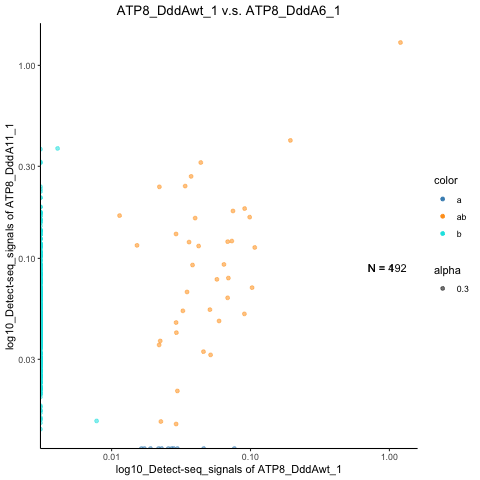

In [238]:
%%R
ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=ATP8_DddAwt_1,
            y=ATP8_DddA6_1,
            alpha=0.3,
            color=color,
            group=color
            # • ‘fill’
            #        • ‘group’
            #        • ‘shape’
            #        • ‘size’
            #        • ‘stroke’
        )
    ) +
    scale_color_manual(values=c("#447B9D", "#ff9f1c", "#e36414")) +
    # scale_x_continuous(
        scale_x_log10(
            name="log10_Detect-seq_signals of ATP8_DddAwt_1",
            # limits=c(0.0001, 1),
            # breaks=c(0.0001, 0.001, 0.01, 0.1, 1),
            # labels = scales: : percent,
        ) +
    # scale_y_continuous(
        scale_y_log10(
            name="log10_Detect-seq_signals of ATP8_DddA11_1",
            # limits=c(0.01, 1200),
            # breaks=c(0.01, 0.1, 1, 10, 100, 1000),
            # labels=c(0.01, 0.1, 1, 10, 100, 1000),
        ) +
    # geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.7, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df[1]))) +
    ggtitle("ATP8_DddAwt_1 v.s. ATP8_DddA6_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))
# annotate("text",x=0.0002,y=500,hjust = 0,parse=TRUE,colour="black", label=sprintf("r == %.3f",pearson_r)) +

In [160]:
%%R
?geom_point

File: /var/folders/03/h9sk2bf52hj_4l4jqzxn17sr0000gn/T//RtmpROGoCS/Rtxt5e4e6246db65
geom_point               package:ggplot2               R Documentation



Points



Description:



     The point geom is used to create scatterplots. The scatterplot is

     most useful for displaying the relationship between two continuous

     variables. It can be used to compare one continuous and one

     categorical variable, or two categorical variables, but a

     variation like ‘geom_jitter()’, ‘geom_count()’, or

     ‘geom_bin2d()’ is usually more appropriate. A _bubblechart_ is a

     scatterplot with a third variable mapped to the size of points.



Usage:



     geom_point(

       mapping = NULL,

       data = NULL,

       stat = "identity",

       position = "identity",

       ...,

       na.rm = FALSE,

       show.legend = NA,

       inherit.aes = TRUE

     )

     

Arguments:



 mapping: Set of aesthetic mappings created by ‘aes()’ or ‘aes_()’.

          If specified 

In [ ]:
ggsave(
    filename="2021-10-14-293T-Merge-Target_seq__vs__Detect_seq.ScatterPlot.pdf",
    width=5.4,
    height=4)

## 2022-10-21 co-localization between all CTCF peaks and Detect-seq signals from different DdCBE treatments

# off-target analysis

## off-target list

### circos plot

#### learn circos plot
- [tutorial1](https://colab.research.google.com/drive/1xmAnv7AHWUTA2HWfjqV1lFWkFMSLJHG0?usp=sharing)
- [tutorial2](https://colab.research.google.com/drive/1RYSo4aXpDIZlSQ9EhO2kPCeF8FOwyvXv?usp=sharing)
- [tutorial3](https://colab.research.google.com/drive/1EPxCQCgOouVxtXcGyxu2ZqQvfucVnOJ-?usp=sharing)
- [tutorial4(Drawing pylogenetic tree)](https://colab.research.google.com/drive/140m2jpQpgSZwSlP-3u3Oj8IcJUbP2NGD?usp=sharing)

In [ ]:
# pip install python-circos

In [ ]:
# !mkdir -p../ temp_file
# % cd../ temp_file
# !mkdir -p pycircos
# % cd pycircos
# !mkdir -p sample_data
# % cd sample_data

In [ ]:
# #The following example data was downloaded from https://venyao.xyz/shinyCircos/.
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_barplot.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_chromosome_cytoband.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_chromosome_general.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_links.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_point.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_rect_gradual.csv

In [ ]:
# % cd / Volumes / zhaohn_HD / 3.project / 2022_DdCBE-3D-Genome_topic / 2022-09-30_Detect-seq_batch-1 / snakepipes_detect-seq

#### circos plot

##### 准备 data

In [ ]:
# 基因组 fai 文件（染色体长度信息），区分 hg19 和 hg38
path_genome_length = '/Users/zhaohuanan/Bio/1.database/db_genomes/genome_fa/genome_ucsc_hg38/genome_ucsc_hg38.fa.fai'
df_genome_length = pd.read_csv(
    path_genome_length,
    header=None,
    sep='\t',
    usecols=[0, 1],
    names=['chrom', 'end'],
)
df_genome_length.insert(loc=1, column='start', value=1)

df_genome_length = df_genome_length\
    .query("chrom != 'chrY'")\
    .query("chrom != 'chrM'")

print(df_genome_length.head(2))

In [ ]:
# cytoband 信息，可以在 ucsc 下载，区分 hg19 和 hg38
df_genome_cytoband = pd.read_csv(
    "http://hgdownload.cse.ucsc.edu/goldenpath/hg38/database/cytoBand.txt.gz",
    header=None,
    sep='\t',
    usecols=range(5),
    names=['chrom', 'start', 'end', 'value1', 'value2'])
# 对 chromosome 进行过滤，保留标准染色体
df_genome_cytoband = df_genome_cytoband\
    .query("not chrom.str.endswith('fix')")\
    .query("not chrom.str.endswith('alt')")\
    .query("not chrom.str.endswith('random')")\
    .query("not chrom.str.startswith('chrUn')")\
    .query("chrom != 'chrY'")\
    .query("chrom != 'chrM'")
print(sorted(df_genome_cytoband.chrom.unique()))
print()
print(df_genome_cytoband.head(2))

In [ ]:
df_circos_point = df_sign_lenient[[
    '<sample>', 'chr_name', 'region_start', 'region_end', 'log2_FC_mut'
]].copy()
df_circos_point.columns = ['sample', 'chrom', 'start', 'end', 'score']
df_circos_point.reset_index(inplace=True, drop=True)
df_circos_point

##### 设置比例尺

In [ ]:
scale = 1.1

In [ ]:
arc_range_i = df_circos_point['sample'].unique().__len__() + 1
arc_raixs_range = ((arc_range_i * 100.0) * scale,
                   (arc_range_i * 100.0 + 20) * scale)
arc_raixs_range

##### 设置染色体信息

In [ ]:
# set chromeosomes
circle = Gcircle()

for idx, row in df_genome_length.iterrows():
    chrom, start, end = row
    length = end - start + 1

    arc = Garc(
        arc_id=chrom,  # 染色体名称
        size=length,  # 染色体长度
        interspace=1,  # 间隔距离
        raxis_range=arc_raixs_range,  # 内外半径长度
        labelposition=60,  # 越往里越小，越往外越大
        label_visible=True,  # 是否展示 label，也就是染色体名称
    )
    circle.add_garc(arc)  # 添加一个染色体信息

circle.set_garcs()  # 整合设置所有添加过的染色体信息

##### 整理 cytoband 信息到arcdata\_dict

In [ ]:
# 定义不同 cytoband 的颜色
color_dict = {
    "gneg": "#FFFFFF00",
    "gpos25": "#EEEEEE",
    "gpos50": "#BBBBBB",
    "gpos75": "#777777",
    "gpos100": "#000000",
    "gvar": "#FFFFFF00",
    "stalk": "#C01E27",
    "acen": "#D82322"
}

# defaultdict的说明
# https://zhuanlan.zhihu.com/p/46476348
# 其实就是当引用的 key 不存在时返回默认值,这里是默认返回一个 dict 而不抛出 KeyError
arcdata_dict = collections.defaultdict(dict)  # 传入 dict 函数，调用时返回空 dict
# or
# arcdata_dict = collections.defaultdict(lambda: {})
# arcdata_dict

for idx, row in df_genome_cytoband.iterrows():
    chrom, start, end, value1, value2 = row
    width = end - start + 1
    # 在进行arcdata_dict对键chrom 取值取不到的时候
    # 默认创建空 dict 而不是 raise KeyError
    if chrom not in arcdata_dict:
        arcdata_dict[chrom]['positions'] = []
        arcdata_dict[chrom]['widths'] = []
        arcdata_dict[chrom]['colors'] = []
    else:
        arcdata_dict[chrom]['positions'].append(start)
        arcdata_dict[chrom]['widths'].append(width)
        arcdata_dict[chrom]['colors'].append(color_dict[value2])

print(arcdata_dict.__str__()[:1000])

##### 将 cytoband 信息加到 circle 对象中去

In [ ]:
for chrom in arcdata_dict:
    circle.barplot(chrom,
                   data=[1] * len(arcdata_dict[chrom]['positions']),
                   positions=arcdata_dict[chrom]['positions'],
                   width=arcdata_dict[chrom]['widths'],
                   raxis_range=arc_raixs_range,
                   facecolor=arcdata_dict[chrom]['colors'])

##### 查看绘制的circos plot骨架

In [ ]:
# circle.figure?
circle.figure

##### 添加每个样本中的 off-target sites 信息

In [ ]:
# TODO
# sample lable
# background color
# point color
# edge color of point

# scatter plot
counter_circle = 0
# color

for sample, sample_df in df_circos_point.groupby('sample'):
    print(sample, sample_df.shape[0])
    counter_circle += 1

    values_all = []
    arcdata_dict = collections.defaultdict(dict)

    for idx, row in sample_df.iterrows():
        _, chrom, start, end, score = row
        middle = (start + end) / 2
        values_all.append(score)

        if chrom not in arcdata_dict:
            arcdata_dict[chrom]["positions"] = []
            arcdata_dict[chrom]["values"] = []
        else:
            arcdata_dict[chrom]["positions"].append(middle)
            arcdata_dict[chrom]["values"].append(score)

    vmin, vmax = min(values_all), max(values_all)

    arc_raixs_range_sample = ((counter_circle * 100.0) * scale,
                              (counter_circle * 100.0 + 80) * scale)

    for chrom in arcdata_dict:
        circle.scatterplot(
            chrom,
            data=arcdata_dict[chrom]["values"],
            positions=arcdata_dict[chrom]["positions"],
            rlim=[vmin - 0.05 * abs(vmin), vmax + 0.05 * abs(vmax)],
            markershape='o',
            markersize=1,
            raxis_range=arc_raixs_range_sample,
            facecolor="#468FBE",
            edgecolor="#000000",
            linewidth=0.03,
            spine=True)

circle.figure

In [ ]:
circle.figure?


### upset plot

## signal strength

### scatter plot

## alignment
### art plot

## editing window
### indel comparation

## ctcf analysis
### shared off-target motif
### DddAwt,6,11 co-localization with ctcf